In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Загрузка данных
df_train = pd.read_csv('mnist_train.csv')
df_test = pd.read_csv('mnist_test.csv')

# Подготовка данных
x_train = df_train.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = df_train.iloc[:, 0].values
x_test = df_test.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_test = df_test.iloc[:, 0].values

# One-hot encoding меток
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

# Функции для слоев сети
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=0, keepdims=True)

def convolve2d(X, K, stride=1):
    X_h, X_w, X_c = X.shape
    K_h, K_w, K_c, K_n = K.shape
    assert X_c == K_c, "Количество каналов в X и K должно совпадать"
    Y_h = (X_h - K_h) // stride + 1
    Y_w = (X_w - K_w) // stride + 1
    Y = np.zeros((Y_h, Y_w, K_n))
    for k in range(K_n):
        for i in range(0, Y_h):
            for j in range(0, Y_w):
                Y[i, j, k] = np.sum(X[i*stride:i*stride+K_h, j*stride:j*stride+K_w, :] * K[:, :, :, k])
    return Y

def pool2d(X, size=2, stride=2, mode='max'):
    X_h, X_w, X_c = X.shape
    Y_h = (X_h - size) // stride + 1
    Y_w = (X_w - size) // stride + 1
    Y = np.zeros((Y_h, Y_w, X_c))
    for c in range(X_c):
        for i in range(0, Y_h):
            for j in range(0, Y_w):
                if mode == 'max':
                    Y[i, j, c] = np.max(X[i*stride:i*stride+size, j*stride:j*stride+size, c])
                elif mode == 'average':
                    Y[i, j, c] = np.mean(X[i*stride:i*stride+size, j*stride:j*stride+size, c])
    return Y

def flatten(X):
    return X.flatten()

def dense(X, W, b):
    return np.dot(X, W) + b

def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-8))

# Инициализация параметров
np.random.seed(0)

# Параметры первого сверточного слоя
conv1_filters = 6
conv1_kernel = np.random.randn(5, 5, 1, conv1_filters) * np.sqrt(2 / (5*5*1))
conv1_bias = np.zeros(conv1_filters)

# Параметры второго сверточного слоя
conv2_filters = 16
conv2_kernel = np.random.randn(5, 5, conv1_filters, conv2_filters) * np.sqrt(2 / (5*5*conv1_filters))
conv2_bias = np.zeros(conv2_filters)

# Параметры полносвязных слоев
fc1_units = 120
fc1_weights = np.random.randn(16*4*4, fc1_units) * np.sqrt(2 / (16*4*4))
fc1_bias = np.zeros(fc1_units)

fc2_units = 84
fc2_weights = np.random.randn(fc1_units, fc2_units) * np.sqrt(2 / fc1_units)
fc2_bias = np.zeros(fc2_units)

fc3_units = 10
fc3_weights = np.random.randn(fc2_units, fc3_units) * np.sqrt(2 / fc2_units)
fc3_bias = np.zeros(fc3_units)

# Прямое распространение
def forward(X):
    cache = {}
    
    # Первый сверточный слой
    conv1 = convolve2d(X, conv1_kernel) + conv1_bias
    conv1 = relu(conv1)  # ReLU активация
    pool1 = pool2d(conv1, mode='average')
    
    # Второй сверточный слой
    conv2 = convolve2d(pool1, conv2_kernel) + conv2_bias
    conv2 = relu(conv2)  # ReLU активация
    pool2 = pool2d(conv2, mode='average')
    
    # Флаттен
    flat = flatten(pool2)
    
    # Полносвязные слои
    fc1 = relu(dense(flat, fc1_weights, fc1_bias))  # ReLU активация
    fc2 = relu(dense(fc1, fc2_weights, fc2_bias))  # ReLU активация
    fc3 = softmax(dense(fc2, fc3_weights, fc3_bias))  # Softmax активация для предсказаний
    
    cache['conv1'] = conv1
    cache['pool1'] = pool1
    cache['conv2'] = conv2
    cache['pool2'] = pool2
    cache['flat'] = flat
    cache['fc1'] = fc1
    cache['fc2'] = fc2
    cache['fc3'] = fc3
    
    return fc3, cache

# Обратное распространение и обновление параметров
def backward(X, y_true, y_pred, cache, learning_rate=0.001):
    global fc3_weights, fc3_bias, fc2_weights, fc2_bias, fc1_weights, fc1_bias
    # Градиенты
    d_loss = y_pred - y_true
    
    # Полносвязные слои
    d_fc3_weights = np.dot(cache['fc2'].reshape(-1, 1), d_loss.reshape(1, -1))
    d_fc3_bias = np.sum(d_loss, axis=0)
    
    d_fc2 = np.dot(d_loss, fc3_weights.T) * relu_derivative(cache['fc2'])
    d_fc2_weights = np.dot(cache['fc1'].reshape(-1, 1), d_fc2.reshape(1, -1))
    d_fc2_bias = np.sum(d_fc2, axis=0)
    
    d_fc1 = np.dot(d_fc2, fc2_weights.T) * relu_derivative(cache['fc1'])
    d_fc1_weights = np.dot(cache['flat'].reshape(-1, 1), d_fc1.reshape(1, -1))
    d_fc1_bias = np.sum(d_fc1, axis=0)
    
    # Обновление параметров полносвязных слоев
    fc3_weights -= learning_rate * d_fc3_weights
    fc3_bias -= learning_rate * d_fc3_bias
    
    fc2_weights -= learning_rate * d_fc2_weights
    fc2_bias -= learning_rate * d_fc2_bias
    
    fc1_weights -= learning_rate * d_fc1_weights
    fc1_bias -= learning_rate * d_fc1_bias

    
# Обучение модели
def train(X_train, y_train, epochs=10, batch_size=32, learning_rate=0.001):
    print("training started")
    for epoch in range(epochs):
        permutation = np.random.permutation(X_train.shape[0])
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for i in range(0, X_train.shape[0], batch_size):
            if (i % 100 == 0):
                print(i, "out of: 60 000") 
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            for j in range(X_batch.shape[0]):
                y_pred, cache = forward(X_batch[j])  # используем одно изображение за раз
                loss = cross_entropy_loss(y_batch[j], y_pred)
                backward(X_batch[j], y_batch[j], y_pred, cache, learning_rate)
        
        print(f'Epoch {epoch+1}, Loss: {loss}')

# Обучение модели
train(x_train, y_train)

training started
0 out of: 60 000
800 out of: 60 000
1600 out of: 60 000
2400 out of: 60 000
3200 out of: 60 000
4000 out of: 60 000
4800 out of: 60 000
5600 out of: 60 000
6400 out of: 60 000
7200 out of: 60 000
8000 out of: 60 000
8800 out of: 60 000
9600 out of: 60 000
10400 out of: 60 000
11200 out of: 60 000
12000 out of: 60 000
12800 out of: 60 000
13600 out of: 60 000
14400 out of: 60 000
15200 out of: 60 000
16000 out of: 60 000
16800 out of: 60 000
17600 out of: 60 000
18400 out of: 60 000
19200 out of: 60 000
20000 out of: 60 000
20800 out of: 60 000
21600 out of: 60 000
22400 out of: 60 000
23200 out of: 60 000
24000 out of: 60 000
24800 out of: 60 000
25600 out of: 60 000
26400 out of: 60 000
27200 out of: 60 000
28000 out of: 60 000
28800 out of: 60 000
29600 out of: 60 000
30400 out of: 60 000
31200 out of: 60 000
32000 out of: 60 000
32800 out of: 60 000
33600 out of: 60 000
34400 out of: 60 000
35200 out of: 60 000
36000 out of: 60 000
36800 out of: 60 000
37600 out of:

In [5]:
# Оценка модели
correct_predictions = 0
for i in range(x_test.shape[0]):
    y_pred, _ = forward(x_test[i])
    if np.argmax(y_pred) == np.argmax(y_test[i]):
        correct_predictions += 1

test_accuracy = correct_predictions / x_test.shape[0]
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.9754


Test accuracy: 0.9754


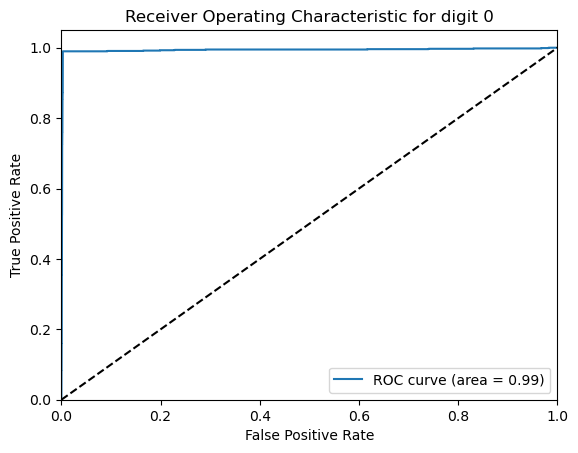

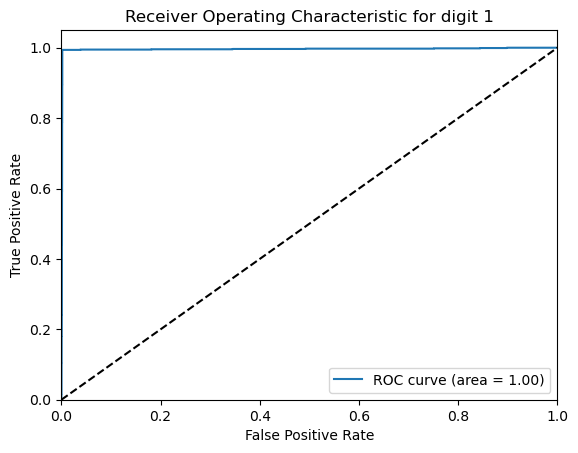

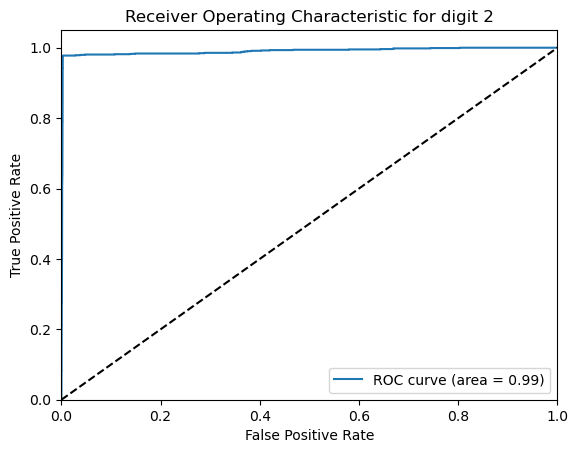

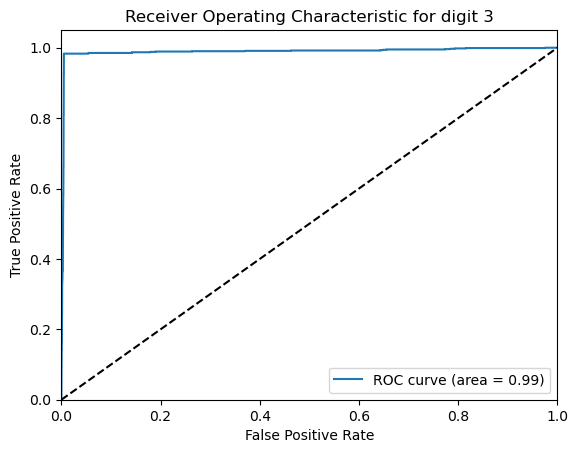

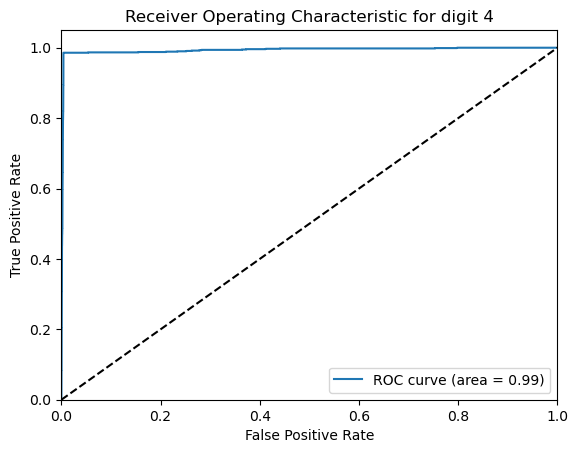

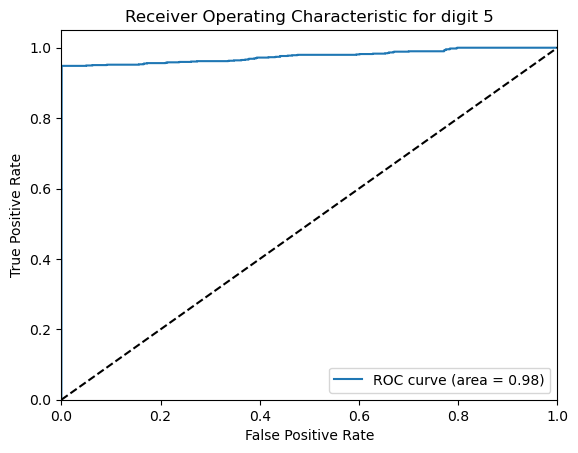

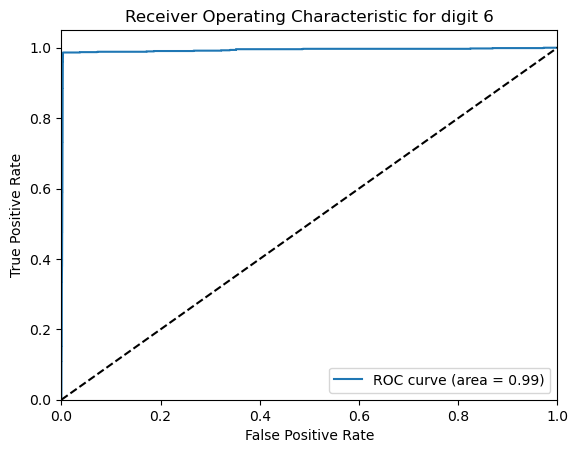

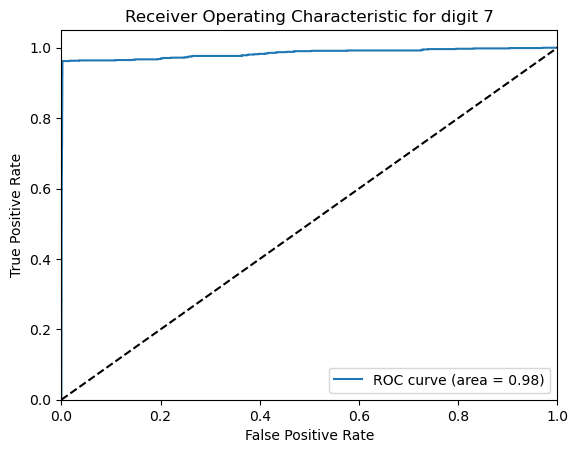

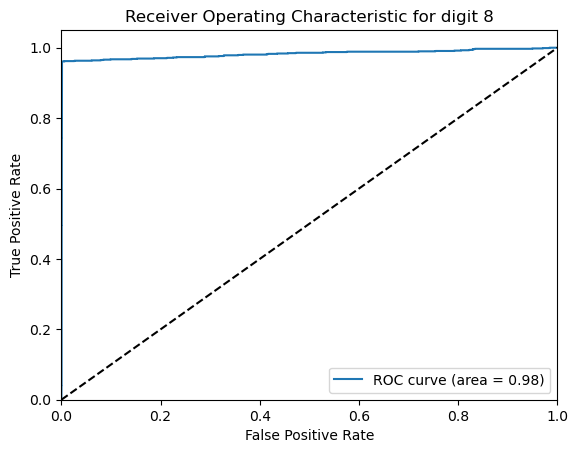

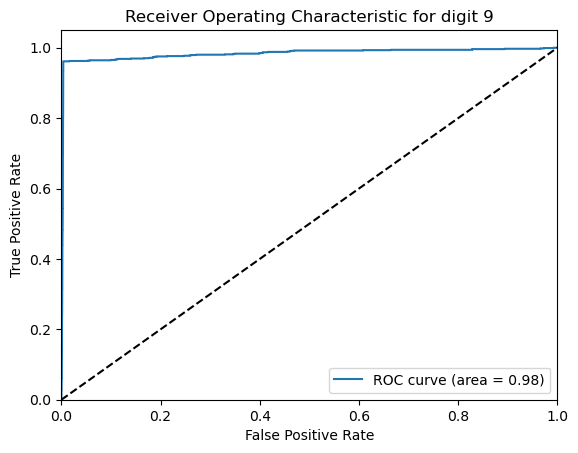

Average Precision: 0.9757
Average Recall: 0.9750
Average F1 Score: 0.9752
Average AUC: 0.9880


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Функции для вычисления метрик
def calculate_precision_recall_f1(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def calculate_auc_roc(y_true, y_scores):
    # Преобразуем y_true и y_scores в одномерные массивы
    y_true = y_true.ravel()
    y_scores = y_scores.ravel()

    # Сортируем значения по убыванию
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]
    
    tpr_list = []
    fpr_list = []
    tp = 0
    fp = 0
    tn = np.sum(y_true == 0)
    fn = np.sum(y_true == 1)

    for i in range(len(y_scores)):
        if y_true[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1
            tn -= 1
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    auc = np.trapz(tpr_list, fpr_list)
    return auc, fpr_list, tpr_list

# Оценка модели
correct_predictions = 0
y_true = []
y_scores = []
for i in range(x_test.shape[0]):
    y_pred, _ = forward(x_test[i])
    y_true.append(np.argmax(y_test[i]))
    y_scores.append(np.argmax(y_pred))
    if np.argmax(y_pred) == np.argmax(y_test[i]):
        correct_predictions += 1

test_accuracy = correct_predictions / x_test.shape[0]
print(f'Test accuracy: {test_accuracy:.4f}')

# Преобразуем y_true и y_scores в массивы numpy
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Преобразование в бинарные метки для каждой цифры (по каждой цифре отдельный расчет метрик)
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for digit in range(10):
    y_true_digit = (y_true == digit).astype(int)
    y_scores_digit = (y_scores == digit).astype(int)
    
    precision, recall, f1 = calculate_precision_recall_f1(y_true_digit, y_scores_digit)
    auc, fpr, tpr = calculate_auc_roc(y_true_digit, y_scores_digit)
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    auc_list.append(auc)
    
    # Построение ROC-кривой для каждой цифры
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for digit {digit}')
    plt.legend(loc="lower right")
    plt.show()

# Вывод средних значений метрик для всех цифр
print(f'Average Precision: {np.mean(precision_list):.4f}')
print(f'Average Recall: {np.mean(recall_list):.4f}')
print(f'Average F1 Score: {np.mean(f1_list):.4f}')
print(f'Average AUC: {np.mean(auc_list):.4f}')
